In [1]:
#import sys
#!{sys.executable} -m pip install futures
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import pandas as pd
from time import time
from concurrent.futures import ThreadPoolExecutor
from scipy.optimize import curve_fit


# Зчитування даних з файлу

In [2]:
with open("corpus/lotr_en.txt") as f:
    file=f.read()
 

print(file)

`the lord of the rings by j r r tolkien part the fellowship of the ring three rings for the elvenkings under the sky seven for the dwarflords in their halls of stone nine for mortal men doomed to die one for the dark lord on his dark throne in the land of mordor where the shadows lie one ring to rule them all one ring to find them one ring to bring them all and in the darkness bind them in the land of mordor where the shadows lie foreword this tale grew in the telling until it became a history of the great war of the ring and included many glimpses of the yet more ancient history that preceded it it was begun soon after the hobbit was written and before its publication in but i did not go on with this sequel for i wished first to complete and set in order the mythology and legends of the elder days which had then been taking shape for some years i desired to do this for my own satisfaction and i had little hope that other people would be interested in this work especially since it was 

In [3]:
import sys
!{sys.executable} -m pip install sklearn



In [5]:
from string import punctuation
def remove_punctuation(data):
    temp=[]
    for i in data:
        if i in punctuation:
            if i == "'" or i == '-'or i==' ':
                temp.append(i.lower())
        else:
            temp.append(i.lower())
    return "".join(temp)
data=remove_punctuation(file)

print(data.split()[:100])



['the', 'lord', 'of', 'the', 'rings', 'by', 'j', 'r', 'r', 'tolkien', 'part', 'the', 'fellowship', 'of', 'the', 'ring', 'three', 'rings', 'for', 'the', 'elvenkings', 'under', 'the', 'sky', 'seven', 'for', 'the', 'dwarflords', 'in', 'their', 'halls', 'of', 'stone', 'nine', 'for', 'mortal', 'men', 'doomed', 'to', 'die', 'one', 'for', 'the', 'dark', 'lord', 'on', 'his', 'dark', 'throne', 'in', 'the', 'land', 'of', 'mordor', 'where', 'the', 'shadows', 'lie', 'one', 'ring', 'to', 'rule', 'them', 'all', 'one', 'ring', 'to', 'find', 'them', 'one', 'ring', 'to', 'bring', 'them', 'all', 'and', 'in', 'the', 'darkness', 'bind', 'them', 'in', 'the', 'land', 'of', 'mordor', 'where', 'the', 'shadows', 'lie', 'foreword', 'this', 'tale', 'grew', 'in', 'the', 'telling', 'until', 'it', 'became']


[  8760 302239 302276 302289 302471 302541 302636 302680 302715 302880
 303419 303528 304544 304585 304818 305180 305262 305339 305418 305514
 305700 305819 305936 305979 306509 306682 306768 306801 307200 307232
 307449 307629 307688 307765 308283 308437 308512 308598 309088 309397
 309758 309863 309900 310204 310348 310501 310737 310812 311018 311260
 311412 311432 311446 311530 311634 311888 311987 312050 312871 312902
 312935 313329 313425 313598 313662 313741 313803 314093 314375 314452
 314462 314542 314563 314587 314680 315155 315247 315363 315474 315533
 315732 315759 315899 315956 316058 316176 316967 317435 317579 317666
 317778 317793 317857 317965 318059 318102 318137 318188 318344 318406
 318492 318537 318570 318625 318648 318704 318800 318824 318916 319035
 319457 319526 319756 319795 319992 320156 320163 320267 320345 320525
 320680 326125 326146 326457 328109 333452 337542 347095 349409 349624
 352489 353245 353297 356028 372888 372928 373000 373254 373257 373353
 37371

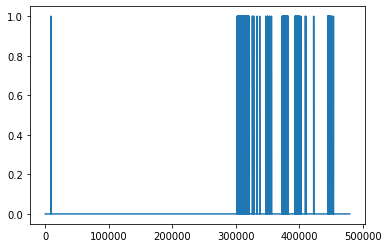

In [48]:

class Ngram (dict):
    def __init__ (self, iterable=None): # Ініціалізували наш розподіл як новий об'єкт класу, додаємо наявні елементи
        super(Ngram, self).__init__()
        self.F_i = 0 # число унікальних ключів в розподілі
        self.fa={}
        self.counts={}
        if iterable:
           self.update (iterable)
    def update (self, iterable): # Оновлюємо розподіл елементами з наявного набору даних
        for item in iterable:
           if item in self:
               self[item]+=1# Абсолютна частота
           else:
                self[item] = 1
                self.F_i+=1
    def hist(self):
        plt.bar(self.keys(),self.values())
        plt.show()

def make_dataframe(model,fmin):# model=словник,fmin=мінімальна абсолютна частота
    filtred_data=list(filter(lambda x:model[x].F_i >=fmin,model))# створюємо новий відфільтровани словник
    data={"ngram":[],
          "F_i":np.empty(len(filtred_data),dtype=np.dtype(int))}# створюємо таблицю 
    for i,ngram in enumerate(filtred_data):# записуємо данні в таблицю
        data["ngram"].append(ngram)
        if ngram=="new_ngram":
            data["F_i"][i]=sum(model[ngram].bool)
            continue
        data["F_i"][i]=len(model[ngram].pos)
    return pd.DataFrame(data=data)

L=0#
V=0#

def make_vocabulary(data,order=1,split='word'):
    #temp_v=[0]
    #temp_l=[0]
    #temp_F=[0]
    model=dict()# словник
    if split=="symbol":# розбиття тексту на сибволи
        temp=[]
        for word in data:
            for symbol in word: 
                temp.append(symbol)
        data=temp
    if split=="letter":#розбиття тексу на літери
        temp=[]
        data.remove_punctuation()
        for word in data:
            for letter in word: 
                temp.append(letter)
        data=temp
    global L
    L=len(data)-order# розмір даних
    model['new_ngram']=Ngram()# додаємо загальний n-грам загальної характеристики всіх n-грам що будуть в словнику
    model['new_ngram'].bool=np.zeros(L)
    if order>1:# якщо n-грам складається більше ніж з одного елемента
        for i in range(L):
            ngram = tuple (data[i: i+order])
            if ngram in model: # Приєднуємо до вже існуючого розподілу
                 model[ngram].update ([data[i+order]])
                 model[ngram].pos.append(i+1)#записуємо положення n-грама в масив [1,3,4]
                 model[ngram].bool[i]=1#записуємо 1 на положенні n-грама в масив [1,0,1,1]
                
            else:
                 model[ngram] = Ngram ([data[i+order]])# добавляємо новий n-грам в словник
                 model[ngram].pos=[]# створюємо новий масив для положень 
                 model[ngram].pos.append(i+1)#додаємо нове положення
                 model[ngram].bool=np.zeros(L)#створюємо масив з 0 і 1, 1 якщо є n-грам, і 0 якщо нема
                 model[ngram].bool[i]=1
                 model['new_ngram'].bool[i]=1
            #temp_v.append(len(model))
            #temp_l.append(i)
            
            
                
                 
                 
    else:#якщо n-грам складається з одного елемента
        for i in range(L):
            if data[i] in model: # Приєднуємо до вже існуючого розподілу
                 model[data[i]].update ([data[i+order]])
                 model[data[i]].pos.append(i+1)
                 model[data[i]].bool[i]=1
                 
                
            else:
                 model[data[i]] = Ngram ([data[i+order]])
                 model[data[i]].pos=[]
                 model[data[i]].pos.append(i+1)
                 model[data[i]].bool=np.zeros(L)
                 model[data[i]].bool[i]=1
                 model['new_ngram'].bool[i]=1
    global V
    V=len(model)
    return model


start=time() # час
#from sklearn.metrics import r2_score
fmin=0# мінімальна частота
order=1#  кількість елементів в n-грамі
split="word" # розбиття тексту



model=make_vocabulary(data.split())
#print(model['faramir'])
ngram='faramir'
print(np.array(model[ngram].pos))
plt.plot(range(L),model[ngram].bool)

def nbc(positions):
    number_of_pos=len(positions)
    if number_of_pos ==1:
        return positions
    dt=np.empty(number_of_pos-1)
    for i in range(number_of_pos-1):
        dt[i]=positions[i+1]-positions[i]-1
    return dt
def R(x):
    if len(x)==1:
        return 0
    t=np.mean(x)
    ts=np.mean(x**2)
    skv=np.sqrt(ts-(t**2))
    return skv/t
print("f: ",len(model[ngram].pos))
dt=nbc(model[ngram].pos)
#print(dt)
r=R(dt)
print("R: ",r)




print("time: ",time()-start)



from os import listdir

#for i in listdir("corpus/"):
#    with open("corpus/"+i) as f:
#        print(i)
#        file=f.read()
#        data=remove_punctuation(file)
#        model,v,l=make_vocabulary(data.split(),order=order,split=split)
#        temp_df.append(len(model[("of","the")].pos))
#        temp_dl.append(L)
#print(1)

#def fit1(x,a,b):
#    return a+(b*x)
#c,cov=curve_fit(fit1,l,v,maxfev=5000,method="lm")
#or i in model:
 #   print(model[i].F_i)
#plt.plot(l,f,"ro")
#plt.plot(l,[fit1(x,c[0],c[1])for x in l])
#print(len(f),len(l))
#df=make_dataframe(model,fmin)
#print("час:",time()-start)
#print("довжина тексу=",L)
#print("довжина словника=",V)
#print(c[0],c[1])
#df.sort_values("F_i")



In [46]:
x=dt
t=np.mean(x)
ts=np.mean(x**2)
#print(t,ts,t**2)
#skv=ts-(t**2)
skv=np.sqrt(ts-t**2)
#print(skv)
r=skv/t
print(r)

11.103646062129144


# make markov chain graph

In [4]:
import networkx as nx
import plotly.graph_objects as go

g=nx.MultiGraph()
temp={}
for ngram in df['ngram']:
    g.add_node(ngram)
    temp[ngram[0]]=ngram
#print(temp.keys())   
for node in g.nodes():
    for i in model[node]:
        if i in temp:
            g.add_edge(node,temp[i],weight=model[node][i])
 

#nx.draw(g)
pos=nx.spring_layout(g)

edge_x = []
edge_y = []
for edge in g.edges():
    x0,y0=pos[edge[0]]
    x1,y1=pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in g.nodes():
    x,y=pos[node]
    node_x.append(x)
    node_y.append(y)
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))
node_adjacencies = []
node_text = []

for node, adjacencies in enumerate(g.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(" ".join(adjacencies[0])+'<br>connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                  
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

# Calculate fa:
1.model[ngram].bool --> [0,0,0,0,0,1,1,0,1,...L]
2.windows(w,we,wh,wmax)

In [101]:
print("order:",order)
print("split by:",split)
print("L:",L)
print("V: ",V)
print("fmin:",fmin)
print("valid V:",len(df['ngram']))
print()
wmax=int(L/20)
w=int(wmax/10)
we=10
wh=int(wmax/2)
print("w:",w)
print("wmax:",wmax)
print("we:",we)
print("wh:",wh)


opt ="no"
print("option:",opt)
#model['entropy'].bool

order: 1
split by: word
L: 479154
V:  14263
fmin: 1000
valid V: 7

w: 2395
wmax: 23957
we: 10
wh: 11978
option: no


## calculate distance (boundary condition)

In [102]:
@jit(nopython=True)
def nbc(positions):
    number_of_pos=len(positions)
    if number_of_pos ==1:
        return positions
    dt=np.empty(number_of_pos-1,dtype=np.uint8)
    for i in range(number_of_pos-1):
        dt[i]=positions[i+1]-positions[i]
    return dt

@jit(nopython=True)
def obc(positions,L):
    number_of_pos=len(positions)
    dt=np.empty(number_of_pos+1,dtype=np.uint8)
    dt[0]=positions[0]
    for i in range(number_of_pos-1):
        dt[i+1]=positions[i+1]-positions[i]
    dt[-1]=L-positions[-1]
    return dt

@jit(nopython=True)
def pbc(positions,L):
    number_of_pos=len(positions)
    dt=np.empty(number_of_pos+1,dtype=np.uint8)
    dt[0]=positions[0]
    for i in range(number_of_pos-1):
        dt[i+1]=positions[i+1]-positions[i]
    dt[-1]=L-positions[-1]+L+positions[0]
    return dt


for index,ngram in enumerate(df['ngram']):
    print(str(index)+" of "+str(len(df['ngram'])),end="\r")
    if ngram=="new_ngram":
        model[ngram].dt=nbc(np.array(model[ngram].bool,dtype=np.uint8))
        continue
    model[ngram].dt=nbc(np.array(model[ngram].pos,dtype=np.uint8))# рахуємо no boudary condition


In [60]:
print("положення n-грама the ")
print(model['the'].pos[:10])
model['the'].dt=nbc(np.array(model['the'].pos,dtype=np.uint8))
print("no boundary condition:")
print(model['the'].dt[:10])
model['the'].dt=obc(np.array(model["the"].pos,dtype=np.uint8),L)
print("ordinary boundary condition:")
print(model['the'].dt[:10])
model['the'].dt=pbc(np.array(model['the'].pos,dtype=np.uint8),L)
print("periodic boundary condition:")
print(model['the'].dt[:10])

положення n-грама the 
[1, 4, 12, 15, 20, 23, 27, 43, 51, 56]
no boundary condition:
[ 3  8  3  5  3  4 16  8  5 22]
ordinary boundary condition:
[ 1  3  8  3  5  3  4 16  8  5]
periodic boundary condition:
[ 1  3  8  3  5  3  4 16  8  5]


NameError: name 'mse' is not defined

In [107]:
start=time()
temp_w=0


#print(df["ngram"])
@jit(nopython=True)
def s(window):
    suma=0
    for i in range(len(window)):
        suma+=window[i]
    return suma
@jit(nopython=True)
def mse(x):
    if len(x)==1:
        return 0
    t=np.mean(x)
    st=np.mean(x**2)
    return np.sqrt(st-(t**2))

@jit(nopython=True)
def R(x):
    if len(x)==1:
        return 0
    t=np.mean(x)
    ts=np.mean(x**2)
    return (ts-(t**2))/t


@jit(nopython=True)
def fa(x,args):# x=масив появи n-грама [1,0,0,...1,0,1], args=параметри вікна 
    wi,wsh,l=args
    count=np.empty(len(range(wi,l,wsh)),dtype=np.uint8)# масив для зберігання кількоскі появ в вікні
    for index,i in enumerate(range(0,l-wi,wh)):
        count[index]=s(x[i:i+wi])# рахуємо кількість появ на вікні
    return count,mse(count) # повертаєво масив з появами та середнє квадратичне відхилення 

from sklearn.metrics import r2_score
windows=list(range(w,wmax,we))
fa(np.zeros(5),(1,2,3))

def func(wind):
    model[ngram].counts[wind],model[ngram].fa[wind]=fa(model[ngram].bool,(wind,wh,L))

for index,ngram in enumerate(df['ngram']):
    print(str(index)+" of "+str(len(df['ngram'])),end="\r")
    with ThreadPoolExecutor() as e:
        e.map(func,windows)
        
 
@jit(nopython=True)
def fit(x,a,b):
    return a*x**b

temp_b=[]
temp_fi=[]
temp_R=[]
temp_cov=[]
temp_a=[]
temp_error=[]
for ngram in df['ngram']:  
    c,cov=curve_fit(fit,[*model[ngram].fa.keys()],[*model[ngram].fa.values()],maxfev=5000)
    model[ngram].a=c[0]
    model[ngram].b=c[1]
    temp_a.append(round(c[0],5))
    temp_b.append(c[1])
    #temp_cov.append(cov)
    temp_error=[fit(w,c[0],c[1]) for w in [*model[ngram].fa.keys()]]
    temp_error=r2_score([*model[ngram].fa.values()],temp_error)
    temp_fi.append(model[ngram].F_i)
    temp_R.append(R(np.array(model[ngram].dt)))
#df['f_i']=temp_fi
df['R']=temp_R
df["a"]=temp_a

df['b']=temp_b
df["goodness"]=temp_error

    

    

    
"""
def secound_pool(ngram):
    return fa(model[ngram].bool,(temp_w,wmax,we,wh,L))

def first_pool(wind):
    #print(w)
    #print(list(df['ngram']))
    #print(model['entropy'])
    global temp_w
    temp_w=wind
    with ThreadPoolExecutor() as j:
        result = j.map(secound_pool,df['ngram'])
    for f,ngram in zip(result,df['ngram']):
        model[ngram].counts[wind]=f[0]
        model[ngram].fa[wind]=f[1]

    
with ThreadPoolExecutor() as e:
    windows=list(range(w,wmax,we))
    e.map(first_pool,windows)
"""


print("fa time:",time()-start)
df

fa time: 11.739306926727295


ngram    F_i   f_i         R         a         b  goodness
0   the  29211  4087  1.132404  38.08664  0.067031  0.918689
1    of  13051  1770  1.043634   2.26484  0.352670  0.918689
2    to   9968  1236  0.966517   0.14652  0.600533  0.918689
3   his   4434  1032  1.012460   0.00500  0.952117  0.918689
4   and  19972  3661  0.960997   8.81209  0.214437  0.918689
5     a   9185  2014  1.010541   0.28701  0.545730  0.918689
6   was   5703  1269  0.947105   0.00000  1.914308  0.918689

початковий розмір вікна: 2395
максимальний розмір вікна: 23957
крок збільшення вікна: 1000
крок зсуву вікна по тексу: 2395
вікіна: [2395, 3395, 4395, 5395, 6395, 7395, 8395, 9395, 10395, 11395, 12395, 13395, 14395, 15395, 16395, 17395, 18395, 19395, 20395, 21395, 22395, 23395]


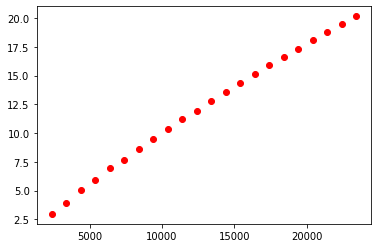

In [81]:
wmax=int(L/20)
w=int(wmax/10)
we=1000
wh=w
print("початковий розмір вікна:",w)
print("максимальний розмір вікна:",wmax)
print("крок збільшення вікна:",we)
print("крок зсуву вікна по тексу:",wh)
windows=list(range(w,wmax,we))
print("вікіна:",windows)
for ww in windows:
    model['lord'].counts[ww],model['lord'].fa[ww]=fa(model['lord'].bool,(ww,wh,L))
plt.plot(model['lord'].fa.keys(),model['lord'].fa.values(),"ro")
plt

In [83]:
def fit(x,a,b):
    return a*x**b

In [69]:
temp_R=[]
for ngram in df['ngram']:
    temp_R.append(R(np.array(model[ngram].dt)))
df["R"]=temp_R
df


ngram    F_i         R
0      new_ngram  14262  5.915674
1            the  29211  1.132404
2           lord    385  0.613914
3             of  13051  1.043634
4          rings     67  0.604888
...          ...    ...       ...
14258      firth      2  0.000000
14259       quay      1  0.000000
14260      narya      1  0.000000
14261    smelled      1  0.000000
14262  homewards      1  0.000000

[14263 rows x 3 columns]

a=0.004708631984857178,b=0.8317578010411971
goodness of fit 0.9998596047606296


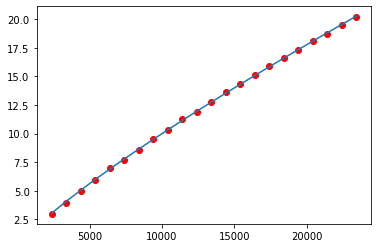

In [97]:
from sklearn.metrics import r2_score
c,cov=curve_fit(fit,[*model['lord'].fa.keys()],[*model['lord'].fa.values()],maxfev=5000,method="lm")
a,b=c[0],c[1]
print("a={0},b={1}".format(a,b))
temp_fa=[fit(w,a,b) for w in model['lord'].fa.keys()]
print("goodness of fit",r2_score([*model['lord'].fa.values()],temp_fa))
plt.plot(model['lord'].fa.keys(),model['lord'].fa.values(),"ro")
plt.plot(model['lord'].fa.keys(),temp_fa)

# DFA

In [213]:
"""
notes 
w=2
wmax=4
wh=1
we=1
one fish two fish tree fish  

new_ngram(1)=[1,1,1,0,1,0]->{'one','fish','tow','fish','tree',"fish"}
dfa(2,3,4)
[1,1][ 1,1 ][1,1][1,1][1,1]->{[one,fish],[fish,two],[two,fish],[fish,tree],[tree,fish]}
[1,1,1][1,1,0][1,1,1][1,0,1]->{[one,fish,two],[fish,two,fish],[two,fish,tree],[fish,tree,fish]}
[1,1,1,0][1,1,0,1][1,1,1,0]->{[one,fish,two,fish],[fish,two,fish,tree],[two,fish,tree,fish]}



new_ngram(2)=[1,1,1,1,1]->[(one,fish),(fish,two),(two,fish),(fish,tree),(tree,fish)]
dfa(2,3,4)
[(one,fish),(fish,two)],[(fish,two),(two,fish)],[(two,fish),(fish,tree)],[(fish,tree),(tree,fish)]
->[1,1],[1,1],[1,1],[1,1]
[(one,fish),(fish,two),(two,fish)],[(fish,two),(two,fish),(fish,tree)],[(two,fish),(fish,tree),(tree,fish)]
->[1,1,1],[1,1,1],[1,1,1]
..


"""
data="one fish two fish tree fish"
#print(list(data[0:2]))
n=1
split="word"
l=0
def prepere_data(data,n,split):
    global l
    temp_data=[]
    if n==1:
        if split=="word":
        #data.replace(" ","space")
            l=len(data.split())
            return data.split()
        if split=='letter':
            data=remove_punctuation(data)
            for i in data:
                for j in i:
                    if j ==" ":
                        continue
                    temp_data.append(j)
            l=len(temp_data)
            return temp_data
        if split=='symbol':
            for i in data:
                for j in i:
                    if j ==" ":
                        temp_data.append("space")
                        continue
                    temp_data.append(j)
            l=len(temp_data)
            return temp_data
    if n>1:
        
        if split=="word":
            data=data.split()
            l=len(data)-n
            for i in range(l):
                window = tuple(data[i: i+n])
                temp_data.append(window)
            return temp_data
        if split=="letter":
            data=remove_punctuation(data.split())
            for i in data:
                for j in i:
                    temp_data.append(j)
            l=len(temp_data)-n
            data=temp_data
            temp_data=[]
            for i in range(l):
                window = tuple (data[i: i+n])
                temp_data.append(window)
            return temp_data
        if split=='symbol':
            temp_data=[]
            for i in data:
                for j in i:
                    if j==" ":
                        temp_data.append("space")
                        continue
                    temp_data.append(j)
            data=temp_data
            temp_data=[]
            l=len(data)-n
            for i in range(l):
                window=tuple(data[i:i+n])
                temp_data.append(window)
            return temp_data
            
            
                
                
            
                
            
        
    
data=prepere_data(data,n,split)
print(data)


w=2
wmax=5
wh=1
we=1
class newNgram():
    def __init__(self,data,wh,l):
        self.data=data
        self.count={}
        self.dfa={}
        self.wh,self.l=wh,l
    @jit(nopython=True)
    def dfa(data,args):
        wi,wh,l=args
        count=np.empty(len(range(wi,l,wh)),dtype=np.uint8)

        for index,i in enumerate(range(0,l-wi,wh)):
            temp_v=[]
            x=[]
            for ngram in data[i:i+wi]:
                if ngram in temp_v:
                    x.append(0)
                else:
                    temp_v.append(ngram)
                    x.append(1)
            count[index]=s(x)
        return count,mse(count)
    def func(self,w):
        
        self.count[w],self.dfa[w]=dfa(self.data,(w,self.wh,self.l))
    
    
        
windows=list(range(w,wmax,we))

print(windows)
print(l)
model={}
new_ngram=newNgram(data,wh,l)
##def func(wind):
 #   ngram.count[wind],ngram.dfa[wind]=dfa(data,(wind,wh,l))
    

  

    

    
    

with ThreadPoolExecutor() as e:
    e.map(new_ngram.func,windows)
new_ngram.dfa


['one', 'fish', 'two', 'fish', 'tree', 'fish']
[2, 3, 4]
6


{2: 0.0, 3: 0.4714045207910318, 4: 0.0}

# Graphs
    


In [48]:
import plotly.express as px
import plotly.graph_objects as go
#fig = px.scatter(
#    df, x='total_bill', y='tip', opacity=0.65,
#    trendline='ols', trendline_color_override='darkblue'
#)
#fig.show()
delta_f=[]
ngram=("of","the")

print(model[ngram].counts.keys())
#print(model[ngram].counts[63])
for w in model[ngram].fa.keys():
    delta_f.append(fit(w,model[ngram].a,model[ngram].b))

fig=go.Figure(
    [
        go.Scatter(x=[*model[ngram].fa.keys()],y=[*model[ngram].fa.values()],mode="markers"),
        go.Scatter(x=[*model[ngram].fa.keys()],y=delta_f)
        
    ]

)
fig.update_xaxes(type="log")
fig.show()

#print(len(np.array(model[ngram].pos)))
#print(len(model[ngram].bool))

print(wh,wh,L)
print(list(range(wh,L,wh)))

fig1=go.Figure(
    [
        go.Scatter(x=np.array(range(L)),y=model[ngram].bool),
        go.Bar(x=np.arange(633,L,wh),y=model[ngram].counts[633])
        #go.Bar(x[model[ngram].count])
    ]
)
#fig1.update_layout(barmode='group')
fig1.show()

temp_hover=[]
for data in df['ngram']:
    
    temp_hover.append(" ".join(data))
    

fig2=go.Figure(
    [
        go.Scatter(x=df['R'],y=df['alpha'],text=temp_hover,mode="markers"),
        
        
    ]
)
#temp_hover
#[*df['ngram']]
fig2.show()

dict_keys([63, 73, 83, 93, 103, 113, 123, 133, 143, 153, 163, 173, 183, 193, 203, 213, 223, 233, 243, 253, 263, 273, 283, 293, 303, 313, 323, 333, 343, 353, 363, 373, 383, 393, 403, 413, 423, 433, 443, 453, 463, 473, 483, 493, 503, 513, 523, 533, 543, 553, 563, 573, 583, 593, 603, 613, 623, 633])


319 319 12766
[319, 638, 957, 1276, 1595, 1914, 2233, 2552, 2871, 3190, 3509, 3828, 4147, 4466, 4785, 5104, 5423, 5742, 6061, 6380, 6699, 7018, 7337, 7656, 7975, 8294, 8613, 8932, 9251, 9570, 9889, 10208, 10527, 10846, 11165, 11484, 11803, 12122, 12441, 12760]


# tests
order: 1
split by: word
L: 479154
V:  14262
fmin: 15
valid V: 1792

w: 4791
wmax: 47915
we: 1000
wh: 4791

# same window for all
fa time: 321.6836111545563 sec/(5,35 m)

# one by one 
fa time: 210.61292123794556 sec/ 3,5 m